In [88]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

DATASET_PATH = "dataset//FOR/for-2sec"

def extract_features(file_path, max_pad_len=174):
    y, sr = librosa.load(file_path, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)

    mfcc = (mfcc - np.mean(mfcc)) / np.std(mfcc)

    # Padding/truncating
    if mfcc.shape[1] < max_pad_len:
        pad_width = max_pad_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :max_pad_len]
    
    return mfcc

def load_dataset(folder):
    X, y = [], []
    for label in ['real', 'fake']:
        folder_path = os.path.join(DATASET_PATH, folder, label)
        for file in tqdm(os.listdir(folder_path), desc=f"Loading {label}"):
            if file.endswith('.wav'):
                file_path = os.path.join(folder_path, file)
                features = extract_features(file_path)
                X.append(features)
                y.append(0 if label == 'real' else 1)
    return np.array(X), np.array(y)

# Load training data
X_train, y_train = load_dataset('training')
X_val, y_val = load_dataset('validation')
X_test, y_test = load_dataset('testing')

print("Shapes:")
print("Train:", X_train.shape, y_train.shape)
print("Val:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)


Loading fake: 100%|█████████████████████████████████████████████████████████████████| 544/544 [00:03<00:00, 138.13it/s]

Shapes:
Train: (13956, 40, 174) (13956,)
Val: (2826, 40, 174) (2826,)
Test: (1088, 40, 174) (1088,)


In [89]:
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]


In [90]:
print("Training data distribution:", np.bincount(y_train))
print("Validation data distribution:", np.bincount(y_val))
print("Test data distribution:", np.bincount(y_test))


Training data distribution: [6978 6978]
Validation data distribution: [1413 1413]
Test data distribution: [544 544]


In [91]:
from tensorflow.keras import layers, models, regularizers

model = models.Sequential([
    layers.Input(shape=(40, 174, 1)),

    # CNN Block
    layers.Conv2D(32, (3, 3), activation='relu',
                  kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),

    layers.Conv2D(64, (3, 3), activation='relu',
                  kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),

    # Reshape CNN output to feed RNN
    layers.Reshape((42, 512)),

    # RNN Block with L2
    layers.Bidirectional(layers.LSTM(64, return_sequences=False,
                                     kernel_regularizer=regularizers.l2(0.001))),
    layers.Dropout(0.4),

    # Dense Output with L2
    layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.4),
    layers.Dense(1, activation='sigmoid',
                 kernel_regularizer=regularizers.l2(0.001))
])



model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_41 (Conv2D)                   │ (None, 38, 172, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 38, 172, 32)         │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_41 (MaxPooling2D)      │ (None, 19, 86, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_69 (Dropout)                 │ (None, 19, 86, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_42 (Conv2D)                   │ (None, 17, 84, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 17, 84, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_42 (MaxPooling2D)      │ (None, 8, 42, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_70 (Dropout)                 │ (None, 8, 42, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_12 (Reshape)                 │ (None, 42, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 128)                 │         295,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_71 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_41 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_72 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_42 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 331,265 (1.26 MB)

 Trainable params: 331,073 (1.26 MB)

 Non-trainable params: 192 (768.00 B)

In [92]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6),
    ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)
]


In [93]:
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=20,
                    batch_size=32,
                    callbacks=[early_stop, checkpoint])


Epoch 1/20
437/437 ━━━━━━━━━━━━━━━━━━━━ 120s 254ms/step - accuracy: 0.5984 - loss: 1.2767 - val_accuracy: 0.5000 - val_loss: 1.3083
Epoch 2/20
437/437 ━━━━━━━━━━━━━━━━━━━━ 110s 252ms/step - accuracy: 0.8333 - loss: 0.6582 - val_accuracy: 0.8025 - val_loss: 0.6061
Epoch 3/20
437/437 ━━━━━━━━━━━━━━━━━━━━ 110s 252ms/step - accuracy: 0.9118 - loss: 0.4119 - val_accuracy: 0.8036 - val_loss: 0.6367
Epoch 4/20
437/437 ━━━━━━━━━━━━━━━━━━━━ 109s 250ms/step - accuracy: 0.9423 - loss: 0.3163 - val_accuracy: 0.5924 - val_loss: 1.3645
Epoch 5/20
437/437 ━━━━━━━━━━━━━━━━━━━━ 113s 259ms/step - accuracy: 0.9530 - loss: 0.2820 - val_accuracy: 0.5248 - val_loss: 1.9704
Epoch 6/20
437/437 ━━━━━━━━━━━━━━━━━━━━ 112s 255ms/step - accuracy: 0.9545 - loss: 0.2724 - val_accuracy: 0.6780 - val_loss: 1.1574
Epoch 7/20
437/437 ━━━━━━━━━━━━━━━━━━━━ 123s 282ms/step - accuracy: 0.9651 - loss: 0.2384 - val_accuracy: 0.9579 - val_loss: 0.2413
Epoch 8/20
437/437 ━━━━━━━━━━━━━━━━━━━━ 109s 249ms/step - accuracy: 0.9682 -

In [94]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.9271 - loss: 0.3071
Test Accuracy: 0.8906, Test Loss: 0.4221


34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step


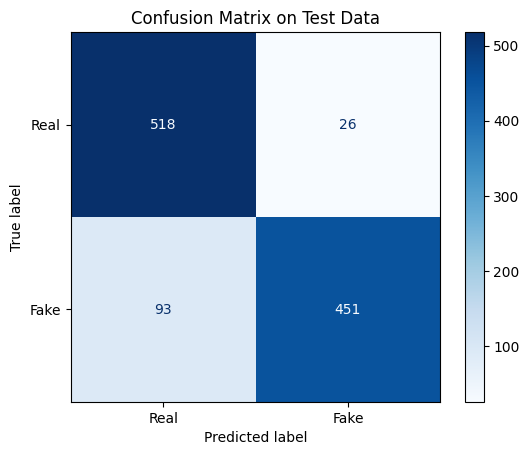

In [95]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assuming your model is called 'model' and test set is X_test, y_test
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1) if y_pred.shape[1] > 1 else (y_pred > 0.5).astype("int32")

cm = confusion_matrix(y_test, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Real", "Fake"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix on Test Data")
plt.show()


In [96]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_classes, target_names=["Real", "Fake"]))


              precision    recall  f1-score   support

        Real       0.85      0.95      0.90       544
        Fake       0.95      0.83      0.88       544

    accuracy                           0.89      1088
   macro avg       0.90      0.89      0.89      1088
weighted avg       0.90      0.89      0.89      1088



In [97]:
# Save the model in HDF5 format
model.save("audio_deepfake_detector1.keras")


In [116]:
import librosa
import numpy as np
from tensorflow.keras.models import load_model

# Step 1: Load and preprocess audio
def preprocess_audio(file_path):
    y, sr = librosa.load(file_path, sr=16000)  # Match your training sample rate
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    
    if mfcc.shape[1] < 174:
        # Pad with zeros
        pad_width = 174 - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :174]  # Trim if longer

    mfcc = mfcc.reshape(1, 40, 174, 1)  # Match model input
    return mfcc

# Step 2: Load your trained model
model = load_model(r"C:\Users\Akshita Asthana\project\audio_deepfake_detector1.keras")  # Update with your model path

# Step 3: Run prediction
file_path = r"C:\Users\Akshita Asthana\Downloads\Recording (8).mp3"  # Update with your audio file
processed = preprocess_audio(file_path)
prediction = model.predict(processed)

# Step 4: Display result
label = "Real" if prediction[0][0] > 0.4 else "Fake"
print(f"Prediction: {label} (Confidence: {prediction[0][0]:.4f})")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
Prediction: Real (Confidence: 0.5128)


In [113]:
import os
import numpy as np
import librosa
from tensorflow.keras.models import load_model

# Load the model
model = load_model("audio_deepfake_detector1.keras")

# Path to test folder
test_folder = r"C:\Audio-Deepfake-Detection\Test"

# Parameters
n_mfcc = 40
max_pad_len = 174

def preprocess_audio(file_path):
    y, sr = librosa.load(file_path, sr=16000)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)

    if mfcc.shape[1] < max_pad_len:
        pad_width = max_pad_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :max_pad_len]

    return mfcc  # shape: (40, 174)

# Predict on all .wav files
for filename in os.listdir(test_folder):
    if filename.endswith(".wav"):
        file_path = os.path.join(test_folder, filename)
        mfcc = preprocess_audio(file_path)
        mfcc = mfcc[np.newaxis, ...]  # shape: (1, 40, 174)

        prediction = model.predict(mfcc)
        label = int(prediction[0][0] >= 0.4)

        print(f"{filename}: {'FAKE' if label == 1 else 'REAL'} (Confidence: {prediction[0][0]:.4f})")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
DeepfakeExample1.wav: FAKE (Confidence: 0.9661)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
DeepfakeExample2.wav: FAKE (Confidence: 0.8000)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
DeepfakeExample3.wav: FAKE (Confidence: 0.6524)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
DeepfakeExample4.wav: FAKE (Confidence: 0.5423)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
DeepfakeExample5.wav: FAKE (Confidence: 0.4326)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
RealExample1.wav: REAL (Confidence: 0.1808)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
RealExample2.wav: REAL (Confidence: 0.1177)


In [71]:
import numpy as np

# Check label distribution
print("Training labels:", np.unique(y_train, return_counts=True))
print("Validation labels:", np.unique(y_val, return_counts=True))


Training labels: (array([0, 1]), array([6978, 6978], dtype=int64))
Validation labels: (array([0, 1]), array([1413, 1413], dtype=int64))


In [72]:
print(np.min(X_train), np.max(X_train), np.mean(X_train), np.std(X_train))


-716.0033 298.6233 -2.537752 34.44208


In [129]:
print(model.input_shape)
model.summary()


(None, 40, 174, 1)


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_41 (Conv2D)                   │ (None, 38, 172, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 38, 172, 32)         │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_41 (MaxPooling2D)      │ (None, 19, 86, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_69 (Dropout)                 │ (None, 19, 86, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_42 (Conv2D)                   │ (None, 17, 84, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 17, 84, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_42 (MaxPooling2D)      │ (None, 8, 42, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_70 (Dropout)                 │ (None, 8, 42, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_12 (Reshape)                 │ (None, 42, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 128)                 │         295,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_71 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_41 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_72 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_42 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 993,413 (3.79 MB)

 Trainable params: 331,073 (1.26 MB)

 Non-trainable params: 192 (768.00 B)

 Optimizer params: 662,148 (2.53 MB)

In [130]:
sample_input = np.random.rand(1, 40, 174, 1).astype(np.float32)
model.predict(sample_input)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


array([[0.8896844]], dtype=float32)

In [153]:
# Load and preprocess the sample audio
sample = preprocess_audio(r"C:\Users\Akshita Asthana\Downloads\Recording (8).mp3")
sample = sample.reshape((1, 40, 174, 1))  # Add batch dimension


In [154]:
# Flatten the sample to (1, 69600)
sample_flat = sample.reshape((1, -1))


In [161]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def interpolate_images(baseline, image, alphas):
    alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]  # Fixed
    delta = image - baseline
    images = baseline + alphas_x * delta
    return images

def compute_gradients(images, model, class_index):
    with tf.GradientTape() as tape:
        tape.watch(images)
        preds = model(images)
        outputs = preds[:, class_index]
    grads = tape.gradient(outputs, images)
    return grads

def integrated_gradients(model, image, class_index, baseline=None, steps=50):
    if baseline is None:
        baseline = tf.zeros_like(image)
    alphas = tf.linspace(0.0, 1.0, steps)
    interpolated = interpolate_images(baseline, image, alphas)
    grads = compute_gradients(interpolated, model, class_index)
    avg_grads = tf.reduce_mean(grads, axis=0)
    integrated_grads = (image - baseline) * avg_grads
    return integrated_grads

# Reshape input
sample = preprocess_audio(r"C:\Users\Akshita Asthana\Downloads\Recording (8).mp3")
sample = sample.reshape((1, 40, 174, 1))
predicted_class = int(model.predict(sample).argmax())

# Compute IG
image_tensor = tf.convert_to_tensor(sample[0], dtype=tf.float32)  # Remove batch dim
ig = integrated_gradients(model, image_tensor, class_index=predicted_class)

# Plot
plt.figure(figsize=(10, 4))
plt.imshow(tf.squeeze(ig).numpy(), cmap='viridis')
plt.colorbar()
plt.title(f"Integrated Gradients - Class {predicted_class}")
plt.axis('off')
plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


LookupError: gradient registry has no entry for: shap_Transpose